<a href="https://colab.research.google.com/github/Jomatrix/Machine-Learning-based-Detection-of-Glaucoma-Disease-using-Retinal-Optic-Data/blob/main/Yolov9_Glaucoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.0/879.0 kB 14.6 MB/s eta 0:00:00


In [ ]:
from roboflow import Roboflow
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
import glob
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
!unzip M_G-DS-1-4.zip

Archive:  M_G-DS-1-4.zip
   creating: M_G-DS-1-4/
  inflating: M_G-DS-1-4/data.yaml    
  inflating: M_G-DS-1-4/README.dataset.txt  
  inflating: M_G-DS-1-4/README.roboflow.txt  
   creating: M_G-DS-1-4/test/
   creating: M_G-DS-1-4/test/images/
  inflating: M_G-DS-1-4/test/images/074_jpg.rf.f548e0760b0d00e24e9010f89c88f2fe.jpg  
  inflating: M_G-DS-1-4/test/images/078_jpg.rf.0337ecf415370f16477c6bf40a7c4c9b.jpg  
  inflating: M_G-DS-1-4/test/images/081_jpg.rf.cc3be1cfc85b489514ea913189f80769.jpg  
  inflating: M_G-DS-1-4/test/images/101_jpg.rf.4b1a7fe14f562fe82791a82e0f26dcf3.jpg  
  inflating: M_G-DS-1-4/test/images/106_jpg.rf.80e19aaa1e0c07357db09e5f2bfc70ec.jpg  
  inflating: M_G-DS-1-4/test/images/107_jpg.rf.2e2af3b621f5265b2b4f59085e8d31d4.jpg  
  inflating: M_G-DS-1-4/test/images/111_jpg.rf.3e34dcef512a07bbc4b0df8e2270fa4b.jpg  
  inflating: M_G-DS-1-4/test/images/117_jpg.rf.9cae682ea4bec4f9e2b8fffc88fbe60e.jpg  
  inflating: M_G-DS-1-4/test/images/362_g_jpg.rf.9ca9d70200a39a862

In [ ]:
!unzip runs.zip

Archive:  runs.zip
   creating: segment/
   creating: segment/train/
   creating: segment/train/weights/
  inflating: segment/train/train_batch1621.jpg  
  inflating: segment/train/val_batch0_labels.jpg  
  inflating: segment/train/MaskR_curve.png  
  inflating: segment/train/BoxPR_curve.png  
  inflating: segment/train/results.csv  
  inflating: segment/train/results.png  
  inflating: segment/train/val_batch1_pred.jpg  
  inflating: segment/train/train_batch1620.jpg  
  inflating: segment/train/train_batch1622.jpg  
  inflating: segment/train/BoxP_curve.png  
  inflating: segment/train/train_batch2.jpg  
  inflating: segment/train/val_batch0_pred.jpg  
  inflating: segment/train/BoxR_curve.png  
  inflating: segment/train/events.out.tfevents.1730292894.39de453ead9d.1073.0  
  inflating: segment/train/MaskP_curve.png  
  inflating: segment/train/labels.jpg  
  inflating: segment/train/train_batch0.jpg  
  inflating: segment/train/confusion_matrix_normalized.png  
  inflating: segment/

In [ ]:
!nvidia-smi

Tue Nov  5 23:51:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
rf = Roboflow(api_key="tjE1Jb1mIVV0c7jL4Wii")
project = rf.workspace("glaucoma-kmplx").project("m_g-ds-1")
version = project.version(4)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to M_G-DS-1-4 in yolov9:: 100%|██████████| 812/812 [00:00<00:00, 3839.07it/s]


In [ ]:
!cat /content/M_G-DS-1-4/data.yaml

names:
- cup
- disc
nc: 2
roboflow:
  license: CC BY 4.0
  project: m_g-ds-1
  url: https://universe.roboflow.com/glaucoma-kmplx/m_g-ds-1/dataset/4
  version: 4
  workspace: glaucoma-kmplx
test: ../test/images
train: ../train/images
val: ../valid/images


In [ ]:
# Build a YOLOv9c model from scratch
model = YOLO("yolov9c-seg.pt")

# Display model information (optional)
model.info()

# Train the model
results = model.train(data='/content/M_G-DS-1-4/data.yaml', epochs=100, imgsz=640, batch=16)


100%|██████████| 53.9M/53.9M [00:02<00:00, 25.7MB/s]


YOLOv9c-seg summary: 654 layers, 27,897,120 parameters, 0 gradients, 159.4 GFLOPs
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov9c-seg.pt, data=/content/M_G-DS-1-4/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

100%|██████████| 755k/755k [00:00<00:00, 48.0MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 218MB/s]


AMP: checks passed ✅


train: Scanning /content/M_G-DS-1-4/train/labels... 280 images, 0 backgrounds, 0 corrupt: 100%|██████████| 280/280 [00:00<00:00, 1598.82it/s]


train: New cache created: /content/M_G-DS-1-4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/M_G-DS-1-4/valid/labels... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<00:00, 1771.24it/s]

val: New cache created: /content/M_G-DS-1-4/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 163 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.8G      2.059      5.526      4.279      2.435         36        640: 100%|██████████| 18/18 [00:23<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all         56        112          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.7G      1.949      4.255      2.794      2.228         44        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         56        112   2.98e-05    0.00893   1.52e-05   1.52e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.7G      1.844      3.794      2.233      2.126         34        640: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         56        112   2.98e-05    0.00893   1.52e-05   1.52e-06          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.7G      1.728      3.498       1.98      2.007         34        640: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         56        112   0.000123     0.0357   8.52e-05   1.79e-05   0.000123     0.0357   8.48e-05   2.54e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.7G      1.679      3.474      1.702      1.938         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         56        112    0.00551        0.5    0.00396    0.00189   0.000906      0.259   0.000781   0.000174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.8G      1.643      3.385      1.623      1.968         30        640: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         56        112     0.0124      0.429     0.0148    0.00668   0.000704     0.0982   0.000426   8.52e-05



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.7G      1.627      3.289       1.52      1.904         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         56        112     0.0269      0.438     0.0164     0.0047    0.00715      0.161    0.00438    0.00106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.8G      1.543      3.158      1.511       1.86         32        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         56        112      0.785       0.25      0.299      0.177      0.604      0.134     0.0946     0.0206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.7G       1.49      3.079      1.399      1.796         21        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.184      0.255      0.188     0.0796      0.649     0.0268     0.0237    0.00395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      12.7G      1.431      2.973      1.358      1.728         51        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         56        112      0.803      0.366      0.367      0.236      0.197      0.205      0.113     0.0168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      12.7G      1.347      2.969       1.28      1.667         44        640: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         56        112      0.738      0.473      0.585      0.367      0.224      0.429       0.24     0.0558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      12.8G      1.351      2.948       1.26      1.662         44        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.743      0.464      0.539      0.302      0.457      0.286      0.228     0.0437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      12.7G      1.342       2.77      1.189      1.685         44        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.671      0.746      0.767      0.457      0.583      0.638      0.617      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.8G      1.335      2.755      1.133      1.665         41        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         56        112      0.804      0.723      0.792      0.443      0.673      0.607      0.594      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      12.7G       1.26      2.645      1.064      1.646         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         56        112      0.659      0.857      0.836      0.504      0.528      0.661      0.541      0.194



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.8G       1.26      2.617     0.9966      1.599         41        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        112       0.74       0.59      0.796      0.489      0.382      0.545       0.58       0.21



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.7G      1.261      2.615     0.9956      1.601         35        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.765      0.911      0.914      0.589      0.755      0.723        0.8      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      12.7G      1.174      2.541     0.9413      1.539         39        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.789      0.938      0.918      0.613      0.771      0.839      0.828      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.7G      1.214      2.522     0.9472      1.568         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         56        112      0.916      0.822       0.93      0.588      0.827      0.741      0.803      0.352



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.8G      1.228      2.534      0.926      1.555         28        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        112      0.835        0.9      0.926      0.588      0.764      0.777      0.803      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.7G      1.179      2.434     0.9089      1.579         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.774      0.931      0.932      0.575      0.671      0.795      0.743      0.324



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.8G      1.181      2.424     0.8767      1.544         39        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         56        112      0.863       0.92      0.947       0.62      0.817      0.857      0.856      0.348



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.7G      1.146      2.467     0.8736      1.517         30        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.898      0.936      0.968      0.616      0.811      0.883      0.836      0.364



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.7G      1.154      2.417     0.8335      1.495         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.918      0.907      0.948      0.618      0.849      0.842      0.856       0.36



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      12.7G      1.192      2.438     0.8477       1.55         28        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.927      0.932      0.962      0.625      0.885      0.893      0.899      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.7G      1.176      2.371     0.8398      1.542         48        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.941      0.929      0.986        0.7      0.906      0.893       0.94      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      12.7G      1.129      2.334     0.7972      1.472         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.903      0.972      0.969      0.662      0.876      0.945      0.924      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.8G       1.13      2.398     0.8223      1.514         20        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         56        112      0.958      0.951      0.976      0.629      0.852      0.843      0.839      0.315



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.7G      1.132       2.33     0.7912      1.501         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         56        112      0.938      0.959       0.98      0.675      0.921      0.943      0.939      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.7G      1.117      2.286     0.7842      1.485         32        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        112      0.864      0.938      0.948        0.6      0.815      0.884      0.891      0.373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      12.7G      1.177      2.369     0.8441      1.546         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all         56        112      0.924      0.952      0.954      0.671      0.872      0.898        0.9      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.8G       1.12      2.306     0.7796       1.45         36        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         56        112      0.975      0.956      0.982      0.679      0.949      0.929      0.952       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.7G      1.108      2.274     0.7931      1.473         40        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.944      0.982      0.988      0.692        0.9      0.938      0.941      0.475



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      12.8G      1.052      2.224     0.7336      1.444         38        640: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         56        112      0.944       0.96      0.966       0.67      0.899      0.916      0.922      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.7G      1.055      2.198     0.7016       1.45         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         56        112      0.956      0.982      0.983      0.668      0.875      0.902      0.883       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.8G      1.084      2.265     0.7057       1.44         39        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.953      0.998      0.993      0.724       0.91      0.953      0.942      0.497



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      12.6G      1.051       2.22     0.7227      1.441         35        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.946      0.946       0.98      0.704      0.902      0.902       0.91      0.451



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.8G      1.112      2.243     0.7266      1.447         42        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.983      0.991      0.994      0.714      0.956      0.964       0.95      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.7G      1.059      2.177      0.678       1.44         39        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.976      0.991      0.992      0.672      0.931      0.946      0.932       0.48



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.7G      1.072      2.235     0.6948      1.424         37        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        112      0.943      0.955      0.984      0.663      0.927      0.938      0.957       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      12.7G      1.081      2.264     0.7424      1.453         35        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.942      0.933      0.969       0.67      0.865      0.853      0.878      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.7G      1.114      2.348     0.7228      1.474         40        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         56        112      0.973      0.988      0.981      0.712      0.938      0.952      0.926      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.7G      1.041      2.179      0.665      1.406         40        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.991          1      0.995        0.7      0.964      0.973      0.966      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.8G      1.033      2.176     0.6539      1.404         32        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.936      0.977      0.973        0.7      0.884      0.923      0.915      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.7G     0.9851       2.17     0.6244       1.39         30        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.985      0.999      0.995      0.719      0.959      0.973      0.963      0.504



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.7G      1.006      2.192     0.6401      1.412         40        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         56        112      0.983      0.991      0.983      0.706      0.957      0.964      0.959       0.51



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.7G     0.9996      2.121     0.6225      1.377         50        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         56        112      0.993          1      0.995      0.729      0.967      0.973      0.972       0.52



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.8G      1.011      2.073     0.6333      1.399         32        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.961      0.991      0.993      0.733      0.926      0.955      0.963      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.7G      1.027      2.134     0.6432      1.391         47        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all         56        112      0.996      0.999      0.995      0.719       0.97      0.972      0.972       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.8G     0.9656      2.048     0.5808      1.352         36        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         56        112      0.986      0.991      0.986      0.698      0.942      0.946      0.938      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.7G     0.9967      2.073     0.6098       1.39         31        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.991          1      0.995      0.728      0.982      0.991      0.986      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.8G      1.012      2.091     0.6209      1.387         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all         56        112      0.983      0.981      0.983       0.73      0.947      0.958      0.965      0.519



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.7G     0.9556      2.042     0.5971      1.349         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         56        112      0.974      0.991      0.983      0.743      0.939      0.955      0.953      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.8G      1.011      2.143     0.6183      1.401         31        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         56        112      0.996      0.997      0.995      0.749      0.952      0.953      0.959      0.525



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.7G     0.9342      2.011     0.5702      1.323         49        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.974          1      0.993      0.742       0.93      0.955      0.951      0.536



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.7G     0.9533      2.033     0.5931      1.373         39        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.978          1      0.995      0.706      0.942      0.964       0.97      0.515



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100      12.7G      1.003      2.083     0.6061      1.378         33        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         56        112      0.996      0.997      0.995      0.701      0.961      0.961       0.97      0.511



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.8G      0.969      2.071     0.5905      1.366         35        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.995          1      0.995      0.736      0.968      0.973      0.971      0.537



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.6G     0.9975      2.152     0.6249      1.395         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.974      0.986      0.995      0.694      0.898       0.92      0.926      0.469



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.8G      0.934      2.009     0.5916      1.348         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         56        112      0.983      0.991      0.984       0.76      0.957      0.964      0.962      0.544



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      12.7G     0.9508      1.971     0.5638      1.345         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.979      0.991      0.985      0.738      0.952      0.964       0.96      0.532



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.8G     0.9535      1.955     0.5588      1.345         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         56        112      0.995          1      0.995      0.732      0.959      0.964      0.957      0.523



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      12.7G     0.9699      1.957     0.5672      1.375         25        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         56        112      0.987          1      0.995      0.752      0.952      0.964      0.972      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.8G     0.9367      1.964     0.5578      1.322         39        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all         56        112      0.995          1      0.995      0.752      0.951      0.955      0.965      0.548



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.7G     0.9415      2.012     0.5849      1.329         33        640: 100%|██████████| 18/18 [00:19<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         56        112      0.994          1      0.995      0.738      0.959      0.964      0.971      0.552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.8G      0.912      1.913     0.5672      1.313         30        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.973      0.991      0.982      0.732      0.938      0.955      0.959      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.7G     0.9123      1.976     0.5503      1.337         28        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         56        112      0.994          1      0.995      0.744      0.958      0.964      0.968      0.558



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.7G     0.9239      1.911     0.5503      1.334         44        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.995          1      0.995      0.757      0.959      0.964      0.966      0.556



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.7G      0.932      1.975     0.5665      1.323         43        640: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.981      0.982      0.988      0.727      0.928      0.929      0.933      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.7G     0.9068      1.984      0.553      1.323         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.995          1      0.995       0.77      0.969      0.973      0.973      0.561



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.7G     0.9169       1.98     0.5457      1.311         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.993          1      0.995      0.745      0.975      0.982      0.983       0.53



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.8G     0.8846      1.928      0.532      1.309         44        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         56        112      0.994          1      0.995      0.735      0.959      0.964      0.969      0.534



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      12.7G     0.9301      1.916     0.5273      1.296         34        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all         56        112      0.996          1      0.995      0.754       0.96      0.964      0.971       0.55



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.8G     0.8668      1.839     0.4974      1.268         38        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.995          1      0.995      0.769       0.96      0.964      0.972      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.7G     0.9024      1.917     0.5056      1.294         24        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all         56        112      0.995          1      0.995      0.759      0.959      0.964      0.973      0.576



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      12.8G     0.8971      1.878     0.5213       1.29         42        640: 100%|██████████| 18/18 [00:19<00:00,  1.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         56        112      0.995          1      0.995      0.771      0.969      0.973       0.98      0.579



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.7G     0.8425      1.829     0.5001      1.289         40        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.995          1      0.995      0.772      0.959      0.964      0.971      0.581



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.8G     0.8637      1.885      0.498       1.28         41        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.995          1      0.995      0.785       0.96      0.964      0.977      0.596



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.7G     0.8688      1.847     0.5194      1.288         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         56        112      0.996          1      0.995      0.772       0.96      0.964      0.976      0.572



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.8G     0.8522      1.815     0.5019      1.279         25        640: 100%|██████████| 18/18 [00:19<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         56        112      0.997          1      0.995      0.777       0.97      0.973      0.981      0.593



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      12.7G     0.8408      1.809     0.5098      1.274         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         56        112      0.997          1      0.995      0.775      0.943      0.946      0.962      0.582



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.8G     0.8673       1.84     0.4913      1.266         36        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         56        112      0.995          1      0.995      0.744       0.96      0.964      0.971      0.535



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.7G     0.8388      1.784     0.4809      1.256         34        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all         56        112      0.996          1      0.995      0.782      0.978      0.982      0.982      0.583



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.7G     0.8575      1.821     0.4789      1.281         43        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         56        112      0.996          1      0.995      0.769      0.979      0.982      0.984      0.573



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.7G     0.8303      1.758     0.4779      1.245         30        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.996          1      0.995      0.769       0.96      0.964      0.973      0.575



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.7G     0.8651       1.83     0.4819      1.276         28        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.996          1      0.995      0.769      0.969      0.973      0.981      0.574



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100      12.7G     0.8304      1.822     0.4814      1.253         37        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         56        112      0.996          1      0.995      0.778      0.961      0.964      0.976      0.606



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.7G     0.8124      1.739     0.4846      1.271         24        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         56        112      0.996          1      0.995      0.788       0.96      0.964      0.976      0.595



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      12.7G     0.8378      1.811     0.5022      1.278         29        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         56        112      0.996          1      0.995      0.795       0.97      0.973      0.979      0.597



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.7G     0.8214      1.808     0.4876      1.264         36        640: 100%|██████████| 18/18 [00:18<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.996          1      0.995      0.796       0.96      0.964      0.969      0.591


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.6G     0.7682      1.626     0.4035      1.374         16        640: 100%|██████████| 18/18 [00:20<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         56        112      0.996          1      0.995      0.793       0.97      0.973      0.971      0.577



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.6G     0.7851      1.632     0.4095      1.397         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         56        112      0.996          1      0.995      0.761      0.978      0.982      0.985      0.566



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.6G     0.7507      1.551     0.3888      1.351         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         56        112      0.996          1      0.995        0.8      0.987      0.991      0.992      0.591



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.6G     0.7397      1.535      0.351      1.305         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.996          1      0.995      0.792      0.987      0.991      0.991      0.578



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.6G     0.7427      1.566     0.3619      1.346         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         56        112      0.996          1      0.995      0.786      0.987      0.991      0.991      0.588



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.6G     0.7408      1.579     0.3991      1.386         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all         56        112      0.996          1      0.995      0.798      0.969      0.973      0.977      0.605



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.6G     0.7092       1.53     0.3613      1.327         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         56        112      0.996          1      0.995      0.793      0.969      0.973       0.98      0.608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.6G     0.6972      1.483     0.3506      1.286         16        640: 100%|██████████| 18/18 [00:19<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all         56        112      0.996          1      0.995      0.801      0.979      0.982      0.986      0.608



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.6G     0.7067      1.518     0.3462      1.309         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all         56        112      0.997          1      0.995      0.797       0.97      0.973       0.98      0.612



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      12.6G     0.7019       1.49     0.3461      1.306         16        640: 100%|██████████| 18/18 [00:18<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         56        112      0.996          1      0.995       0.79       0.97      0.973       0.98      0.608



100 epochs completed in 0.656 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 56.2MB
Optimizer stripped from runs/segment/train/weights/best.pt, 56.2MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.24 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9c-seg summary (fused): 411 layers, 27,626,070 parameters, 0 gradients, 157.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


                   all         56        112      0.996          1      0.995      0.803      0.979      0.982      0.986      0.609
                   cup         56         56      0.999          1      0.995      0.698      0.999          1      0.995      0.674
                  disc         56         56      0.994          1      0.995      0.908      0.958      0.964      0.977      0.545
Speed: 0.2ms preprocess, 21.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/segment/train


In [ ]:
import shutil

# Compress the 'runs' folder into a zip file
shutil.make_archive('/content/M_G-DS-1-4', 'zip', '/content/M_G-DS-1-4')

# Download the zip file
from google.colab import files
files.download('/content/M_G-DS-1-4.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = YOLO('/content/segment/train/weights/best.pt')

# Run inference with the YOLOv9c model on the 'bus.jpg' image
results = model('/content/M_G-DS-1-4/test/images/074_jpg.rf.f548e0760b0d00e24e9010f89c88f2fe.jpg')



image 1/1 /content/M_G-DS-1-4/test/images/074_jpg.rf.f548e0760b0d00e24e9010f89c88f2fe.jpg: 640x640 1 cup, 1 disc, 62.2ms
Speed: 5.5ms preprocess, 62.2ms inference, 735.3ms postprocess per image at shape (1, 3, 640, 640)


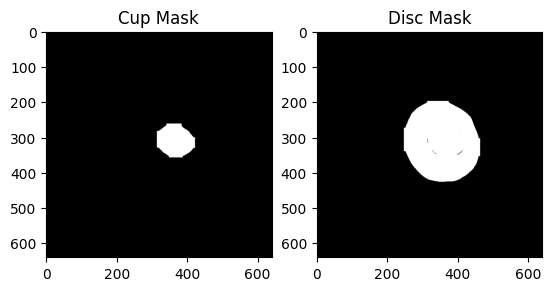

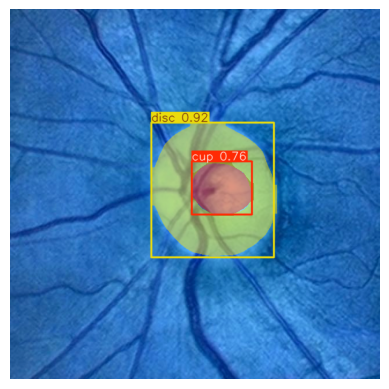

In [ ]:
# Function to combine cup and disc masks if necessary
def ensure_full_disc_mask(cup_mask, disc_mask):
    # Ensure the disc mask contains the cup area as well (if cup lies within disc)
    combined_mask = cv2.bitwise_or(disc_mask, cup_mask)  # Combining cup and disc regions
    return combined_mask

# Results contain the predicted masks
# For a segmentation task, 'masks' are stored in results.masks.data
masks = results[0].masks  # Assuming single image in results

# Check if masks exist in the results
if masks is not None:
    # Get the masks for cup and disc
    # Convert the tensor mask to numpy arrays
    mask_array = masks.data.cpu().numpy()  # Move masks to CPU and convert to numpy

    # For demonstration, assuming mask 0 is for the cup and mask 1 is for the disc
    cup_mask = mask_array[1]
    disc_mask = mask_array[0]

  # Ensure the disc mask fully includes the cup
    disc_mask = ensure_full_disc_mask(cup_mask, disc_mask)
    # Optionally, you can threshold the mask to make it binary (if needed)
    # For binary masks, use a threshold (e.g., 0.5)
    cup_mask_binary = (cup_mask > 0.5).astype('uint8')  # Convert to 0 or 1
    disc_mask_binary = (disc_mask > 0.5).astype('uint8')  # Convert to 0 or 1

    # Display the masks
    plt.subplot(1, 2, 1)
    plt.imshow(cup_mask_binary, cmap='gray')
    plt.title("Cup Mask")

    plt.subplot(1, 2, 2)
    plt.imshow(disc_mask_binary, cmap='gray')
    plt.title("Disc Mask")

    plt.show()
else:
    print("No masks found in the results.")


# Display the image with predictions
# Extract the annotated image with results
annotated_img = results[0].plot()  # 'plot()' returns the image with annotations

# Option 1: Display with Matplotlib (recommended for Colab)
plt.imshow(annotated_img)
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
def calculate_diameters_and_area(mask):
    # Find contours of the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None, None  # Return None if no contours found

    # Get the largest contour (assuming it's the segmented object)
    contour = max(contours, key=cv2.contourArea)

    # Fit a bounding box to the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Vertical and Horizontal diameters (height and width of the bounding box)
    vertical_diameter = h
    horizontal_diameter = w

    # Calculate area of the segmented region
    area = cv2.contourArea(contour)

    return vertical_diameter, horizontal_diameter, area

# Function to combine cup and disc masks if necessary
def ensure_full_disc_mask(cup_mask, disc_mask):
    # Ensure the disc mask contains the cup area as well (if cup lies within disc)
    combined_mask = cv2.bitwise_or(disc_mask, cup_mask)  # Combining cup and disc regions
    return combined_mask

# Assuming cup_mask and disc_mask are your binary segmentation masks
# (output from the model after segmentation)
cup_mask = cup_mask_binary
disc_mask = disc_mask_binary

# Ensure the disc mask fully includes the cup
adjusted_disc_mask = ensure_full_disc_mask(cup_mask, disc_mask)

# Get the diameters and area for cup and disc
cup_v_diameter, cup_h_diameter, cup_area = calculate_diameters_and_area(cup_mask)
disc_v_diameter, disc_h_diameter, disc_area = calculate_diameters_and_area(adjusted_disc_mask)

# Ensure valid results
if cup_v_diameter and disc_v_diameter and cup_area and disc_area:
    # Calculate VCDR, HCDR, and CDAR
    VCDR = cup_v_diameter / (disc_v_diameter)
    HCDR = cup_h_diameter / (disc_h_diameter)
    CDAR = cup_area / (disc_area)

    print(f"VCDR: {VCDR}")
    print(f"HCDR: {HCDR}")
    print(f"CDAR: {CDAR}")

    # Now you can use these values as features for SVM
    features = np.array([VCDR, HCDR, CDAR])

    # Proceed with storing or using these features for your SVM model
else:
    print("Segmentation failed for either cup or disc.")


VCDR: 0.4192139737991266
HCDR: 0.5
CDAR: 0.20325245224574084


In [ ]:
# Function to ensure the disc mask fully includes the cup
def ensure_full_disc_mask(cup_mask, disc_mask):
    combined_mask = cv2.bitwise_or(disc_mask, cup_mask)
    return combined_mask

# Function to calculate diameters and area from a mask
def calculate_diameters_and_area(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None, None

    contour = max(contours, key=cv2.contourArea)

    x, y, w, h = cv2.boundingRect(contour)
    vertical_diameter = h
    horizontal_diameter = w

    area = cv2.contourArea(contour)

    return vertical_diameter, horizontal_diameter, area

# Load your YOLO model
model = YOLO('/content/segment/train/weights/best.pt')

# Path to your image folder
image_folder = '/content/M_G-DS-1-4/train/images'

# Get list of all images in the folder
image_paths = glob.glob(os.path.join(image_folder, '*.jpg'))

# Prepare a list to store the results
results_list = []

# Loop over all images
for image_path in image_paths:
    print(f"Processing {image_path}")
    results = model(image_path)

    # Get masks from the results
    masks = results[0].masks

    if masks is not None:
        # Convert masks to NumPy arrays
        mask_array = masks.data.cpu().numpy()

        # Ensure at least two masks are detected (disc and cup)
        if mask_array.shape[0] >= 2:
            # Assuming mask_array[0] is disc and mask_array[1] is cup
            disc_mask = mask_array[0]
            cup_mask = mask_array[1]

            # Threshold the masks to get binary values
            cup_mask_binary = (cup_mask > 0.5).astype('uint8')
            disc_mask_binary = (disc_mask > 0.5).astype('uint8')

            # Ensure the disc mask fully includes the cup
            adjusted_disc_mask = ensure_full_disc_mask(cup_mask_binary, disc_mask_binary)

            # Calculate features
            cup_v_diameter, cup_h_diameter, cup_area = calculate_diameters_and_area(cup_mask_binary)
            disc_v_diameter, disc_h_diameter, disc_area = calculate_diameters_and_area(adjusted_disc_mask)

            if None not in [cup_v_diameter, disc_v_diameter, cup_area, disc_area]:
                VCDR = cup_v_diameter / disc_v_diameter
                HCDR = cup_h_diameter / disc_h_diameter
                CDAR = cup_area / disc_area

                print(f"VCDR: {VCDR}")
                print(f"HCDR: {HCDR}")
                print(f"CDAR: {CDAR}")

                # Append the results
                results_list.append({
                    'Image': os.path.basename(image_path),
                    'VCDR': VCDR,
                    'HCDR': HCDR,
                    'CDAR': CDAR
                })
            else:
                print("Segmentation failed for either cup or disc.")
        else:
            print(f"Not enough masks detected in {image_path}")
    else:
        print("No masks found in the results.")

# Save the results to CSV
df = pd.DataFrame(results_list)
output_csv_path = '/content/train.csv'
df.to_csv(output_csv_path, index=False)
print(f"Features saved to {output_csv_path}")

Processing /content/M_G-DS-1-4/train/images/076_g_jpg.rf.bf710094679793f97a177f907976e252.jpg

image 1/1 /content/M_G-DS-1-4/train/images/076_g_jpg.rf.bf710094679793f97a177f907976e252.jpg: 640x640 1 cup, 1 disc, 62.3ms
Speed: 2.1ms preprocess, 62.3ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
VCDR: 0.6857142857142857
HCDR: 0.7846153846153846
CDAR: 0.5366249607605722
Processing /content/M_G-DS-1-4/train/images/258_jpg.rf.11739a692001f24aed3ec30f720387f4.jpg

image 1/1 /content/M_G-DS-1-4/train/images/258_jpg.rf.11739a692001f24aed3ec30f720387f4.jpg: 640x640 1 cup, 1 disc, 55.0ms
Speed: 2.1ms preprocess, 55.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)
VCDR: 0.5666666666666667
HCDR: 0.6181818181818182
CDAR: 0.34722568734095105
Processing /content/M_G-DS-1-4/train/images/drishtiGS_050_g_jpg.rf.46f219526eeabc79ca54da696270f305.jpg

image 1/1 /content/M_G-DS-1-4/train/images/drishtiGS_050_g_jpg.rf.46f219526eeabc79ca54da696270f305.jpg: 640x640 1 cu

**RESULT FOR COMBINING ALL THREE FEATURES IN SVM CLASSIFIER**

Accuracy: 89.17%
Sensitivity (Recall): 0.90
Specificity: 0.89
Precision: 0.88
F1 Score: 0.89
AUC: 0.93

Classification Report:
              precision    recall  f1-score   support

Non-Glaucoma       0.90      0.89      0.89        61
    Glaucoma       0.88      0.90      0.89        59

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



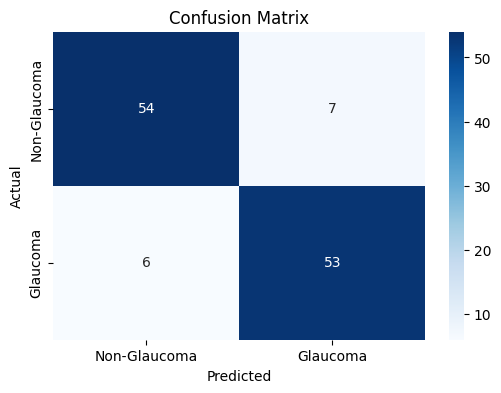

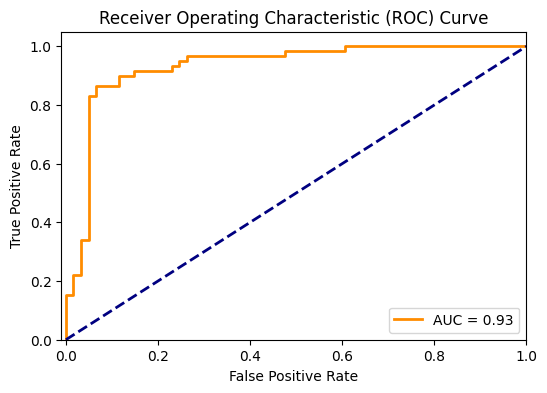

In [ ]:
# Load the CSV files
train_df = pd.read_csv('/content/train.csv')
valid_df = pd.read_csv('/content/valid.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine train and valid dataframes for training
test_valid_df = pd.concat([test_df, valid_df], ignore_index=True)

# Function to assign labels based on filename
def assign_label(filename):
    if '_g' in filename:
        return 1  # Glaucoma
    else:
        return 0  # Non-glaucoma

# Apply the function to create labels
train_df['Label'] = train_df['Image'].apply(assign_label)
test_valid_df['Label'] = test_valid_df['Image'].apply(assign_label)

# Extract features and labels
X_train = train_df[['VCDR', 'HCDR', 'CDAR']]
y_train = train_df['Label']

X_test = test_valid_df[['VCDR', 'HCDR', 'CDAR']]
y_test = test_valid_df['Label']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the SVM classifier
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Predict on test data
y_pred = svm_classifier.predict(X_test_scaled)
y_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for positive class
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
auc = roc_auc_score(y_test, y_proba)

# Print the metrics
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'AUC: {auc:.2f}\n')

# Classification report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=['Non-Glaucoma', 'Glaucoma']))

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Glaucoma', 'Glaucoma'],
            yticklabels=['Non-Glaucoma', 'Glaucoma'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

**RESULT FOR SVM CLASSIFIER USING ALL COMBINATION OF THE FEATURES**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV files
train_df = pd.read_csv('/content/train.csv')
valid_df = pd.read_csv('/content/valid.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine train and valid dataframes for training
test_valid_df = pd.concat([test_df, valid_df], ignore_index=True)

# Function to assign labels based on filename
def assign_label(filename):
    return 1 if '_g' in filename else 0

# Apply the function to create labels
train_df['Label'] = train_df['Image'].apply(assign_label)
test_valid_df['Label'] = test_valid_df['Image'].apply(assign_label)

# Feature combinations to test
feature_combinations = {
    'VCDR, HCDR, CDAR': ['VCDR', 'HCDR', 'CDAR'],
    'HCDR': ['HCDR'],
    'VCDR': ['VCDR'],
    'CDAR': ['CDAR'],
    'HCDR, VCDR': ['HCDR', 'VCDR'],
    'HCDR, CDAR': ['HCDR', 'CDAR'],
    'CDAR, VCDR': ['CDAR', 'VCDR']
}

# Dictionary to store results
results = []

# Loop through each feature combination
for name, features in feature_combinations.items():
    # Extract features and labels
    X_train = train_df[features]
    y_train = train_df['Label']
    X_test = test_valid_df[features]
    y_test = test_valid_df['Label']

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train the SVM classifier
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)

    # Predict on test data
    y_pred = svm_classifier.predict(X_test_scaled)
    y_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    auc = roc_auc_score(y_test, y_proba)

    # Store results
    results.append({
        'Features': name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1 Score': f1,
        'AUC': auc
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


           Features  Accuracy  Sensitivity  Specificity  Precision  F1 Score  \
0  VCDR, HCDR, CDAR  0.891667     0.898305     0.885246   0.883333  0.890756   
1              HCDR  0.816667     0.881356     0.754098   0.776119  0.825397   
2              VCDR  0.900000     0.881356     0.918033   0.912281  0.896552   
3              CDAR  0.875000     0.881356     0.868852   0.866667  0.873950   
4        HCDR, VCDR  0.883333     0.881356     0.885246   0.881356  0.881356   
5        HCDR, CDAR  0.875000     0.881356     0.868852   0.866667  0.873950   
6        CDAR, VCDR  0.900000     0.898305     0.901639   0.898305  0.898305   

        AUC  
0  0.931370  
1  0.919700  
2  0.904696  
3  0.918588  
4  0.934148  
5  0.934148  
6  0.910809  


**RESULT FOR COMBINING ALL THREE FEATURES IN SVM CLASSIFIER (3-fold) **

Average Metrics across all folds:
Accuracy: 82.51%
Sensitivity (Recall): 0.79
Specificity: 0.86
Precision: 0.85
F1 Score: 0.82
AUC: 0.88

Test Set Metrics:
Accuracy: 89.17%
Sensitivity (Recall): 0.90
Specificity: 0.89
Precision: 0.88
F1 Score: 0.89
AUC: 0.93

Classification Report (Test Set):
              precision    recall  f1-score   support

Non-Glaucoma       0.90      0.89      0.89        61
    Glaucoma       0.88      0.90      0.89        59

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



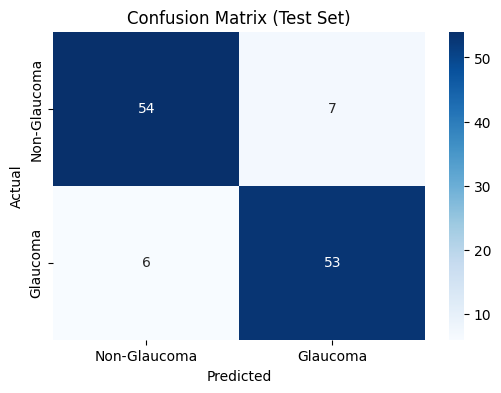

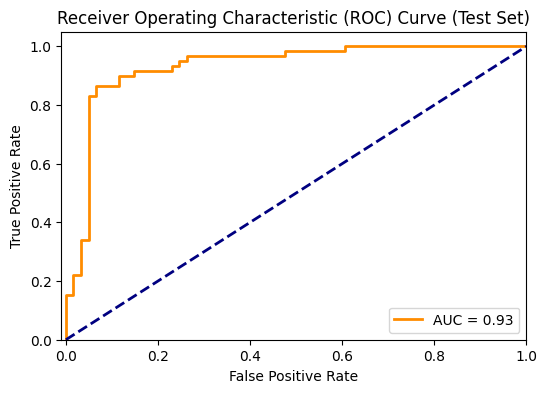

In [ ]:
# Load the CSV files
train_df = pd.read_csv('/content/train.csv')
valid_df = pd.read_csv('/content/valid.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine train and valid dataframes for training
test_valid_df = pd.concat([test_df, valid_df], ignore_index=True)

# Function to assign labels based on filename
def assign_label(filename):
    return 1 if '_g' in filename else 0

# Apply the function to create labels
train_df['Label'] = train_df['Image'].apply(assign_label)
test_valid_df['Label'] = test_valid_df['Image'].apply(assign_label)

# Define feature set and label for training and test sets
X = train_df[['VCDR', 'HCDR', 'CDAR']]
y = train_df['Label']
X_test = test_valid_df[['VCDR', 'HCDR', 'CDAR']]
y_test = test_valid_df['Label']

# Define k-fold cross-validation (Stratified to preserve class distribution)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize lists to store metrics for each fold
accuracy_list = []
auc_list = []
sensitivity_list = []
specificity_list = []
precision_list = []
f1_list = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X, y):
    # Split into training and validation sets for this fold
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Standardize the features using training set statistics
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train the SVM classifier
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)

    # Predict on the validation set
    y_val_pred = svm_classifier.predict(X_val_scaled)
    y_val_proba = svm_classifier.predict_proba(X_val_scaled)[:, 1]

    # Calculate metrics for this fold
    accuracy = accuracy_score(y_val, y_val_pred)
    cm = confusion_matrix(y_val, y_val_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)  # Recall for positive class
    specificity = tn / (tn + fp)
    precision = tp / (tp + fp)
    f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
    auc = roc_auc_score(y_val, y_val_proba)

    # Store metrics
    accuracy_list.append(accuracy)
    auc_list.append(auc)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    precision_list.append(precision)
    f1_list.append(f1)

# Average metrics across folds
print('Average Metrics across all folds:')
print(f'Accuracy: {np.mean(accuracy_list)*100:.2f}%')
print(f'Sensitivity (Recall): {np.mean(sensitivity_list):.2f}')
print(f'Specificity: {np.mean(specificity_list):.2f}')
print(f'Precision: {np.mean(precision_list):.2f}')
print(f'F1 Score: {np.mean(f1_list):.2f}')
print(f'AUC: {np.mean(auc_list):.2f}\n')

# Now, train on the entire training set and evaluate on the test set
scaler = StandardScaler()
X_train_valid_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)  # Use the same scaler for test set

svm_classifier.fit(X_train_valid_scaled, y)  # Train on full training data

# Predict on the test data
y_test_pred = svm_classifier.predict(X_test_scaled)
y_test_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics on test set
accuracy_test = accuracy_score(y_test, y_test_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
sensitivity_test = tp / (tp + fn)
specificity_test = tn / (tn + fp)
precision_test = tp / (tp + fp)
f1_test = 2 * (precision_test * sensitivity_test) / (precision_test + sensitivity_test)
auc_test = roc_auc_score(y_test, y_test_proba)

# Print test set metrics
print(f'Test Set Metrics:')
print(f'Accuracy: {accuracy_test*100:.2f}%')
print(f'Sensitivity (Recall): {sensitivity_test:.2f}')
print(f'Specificity: {specificity_test:.2f}')
print(f'Precision: {precision_test:.2f}')
print(f'F1 Score: {f1_test:.2f}')
print(f'AUC: {auc_test:.2f}\n')

# Classification report for test set
print('Classification Report (Test Set):')
print(classification_report(y_test, y_test_pred, target_names=['Non-Glaucoma', 'Glaucoma']))

# Confusion Matrix Heatmap for test set
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Glaucoma', 'Glaucoma'],
            yticklabels=['Non-Glaucoma', 'Glaucoma'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Test Set)')
plt.show()

# ROC Curve for test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Load the CSV files
train_df = pd.read_csv('/content/train.csv')
valid_df = pd.read_csv('/content/valid.csv')
test_df = pd.read_csv('/content/test.csv')

# Combine train and valid dataframes for training
test_valid_df = pd.concat([test_df, valid_df], ignore_index=True)

# Function to assign labels based on filename
def assign_label(filename):
    return 1 if '_g' in filename else 0

# Apply the function to create labels
train_df['Label'] = train_df['Image'].apply(assign_label)
test_valid_df['Label'] = test_valid_df['Image'].apply(assign_label)

# Define feature combinations
feature_combinations = {
    'HCDR, VCDR, CDAR': ['HCDR', 'VCDR', 'CDAR'],
    'HCDR': ['HCDR'],
    'VCDR': ['VCDR'],
    'CDAR': ['CDAR'],
    'HCDR, VCDR': ['HCDR', 'VCDR'],
    'HCDR, CDAR': ['HCDR', 'CDAR'],
    'CDAR, VCDR': ['CDAR', 'VCDR']
}

# Dictionary to store final results
results_summary = []

# Define k-fold cross-validation (Stratified to preserve class distribution)
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop through each feature combination
for name, features in feature_combinations.items():
    # Extract features and labels
    X = train_df[features]
    y = train_df['Label']
    X_test = test_valid_df[features]
    y_test = test_valid_df['Label']

    # Initialize lists to store metrics for each fold
    accuracy_list = []
    auc_list = []
    sensitivity_list = []
    specificity_list = []
    precision_list = []
    f1_list = []

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X, y):
        # Split into training and validation sets for this fold
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Standardize the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Train the SVM classifier
        svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
        svm_classifier.fit(X_train_scaled, y_train)

        # Predict on the validation set
        y_val_pred = svm_classifier.predict(X_val_scaled)
        y_val_proba = svm_classifier.predict_proba(X_val_scaled)[:, 1]

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        cm = confusion_matrix(y_val, y_val_pred)
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        precision = tp / (tp + fp)
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity)
        auc = roc_auc_score(y_val, y_val_proba)

        # Store metrics for each fold
        accuracy_list.append(accuracy)
        auc_list.append(auc)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        precision_list.append(precision)
        f1_list.append(f1)



    # Average metrics across folds
    avg_accuracy = np.mean(accuracy_list)
    avg_auc = np.mean(auc_list)
    avg_sensitivity = np.mean(sensitivity_list)
    avg_specificity = np.mean(specificity_list)
    avg_precision = np.mean(precision_list)
    avg_f1 = np.mean(f1_list)

    # Standardize and evaluate on test set
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(X_test)
    svm_classifier.fit(X_train_scaled, y)  # Train on full train data

    # Predict on the test data
    y_test_pred = svm_classifier.predict(X_test_scaled)
    y_test_proba = svm_classifier.predict_proba(X_test_scaled)[:, 1]

    # Test set metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm_test.ravel()
    test_sensitivity = tp / (tp + fn)
    test_specificity = tn / (tn + fp)
    test_precision = tp / (tp + fp)
    test_f1 = 2 * (test_precision * test_sensitivity) / (test_precision + test_sensitivity)
    test_auc = roc_auc_score(y_test, y_test_proba)

    # Append results
    results_summary.append({
        'Features': name,
        'CV Accuracy': avg_accuracy,
        'CV Sensitivity': avg_sensitivity,
        'CV Specificity': avg_specificity,
        'CV Precision': avg_precision,
        'CV F1 Score': avg_f1,
        'CV AUC': avg_auc,
        'Test Accuracy': test_accuracy,
        'Test Sensitivity': test_sensitivity,
        'Test Specificity': test_specificity,
        'Test Precision': test_precision,
        'Test F1 Score': test_f1,
        'Test AUC': test_auc
    })

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.4f}".format)
pd.set_option("display.colheader_justify", "center")
pd.set_option("display.width", 1000)


display(results_df)
results_df = pd.DataFrame(results_summary)


,Features,CV Accuracy,CV Sensitivity,CV Specificity,CV Precision,CV F1 Score,CV AUC,Test Accuracy,Test Sensitivity,Test Specificity,Test Precision,Test F1 Score,Test AUC
0,"HCDR, VCDR, CDAR",0.8251,0.7899,0.8596,0.8494,0.8170,0.8816,0.8917,0.8983,0.8852,0.8833,0.8908,0.9314
1,HCDR,0.7610,0.8261,0.6978,0.7267,0.7725,0.8129,0.8167,0.8814,0.7541,0.7761,0.8254,0.9197
2,VCDR,0.8143,0.7754,0.8524,0.8390,0.8046,0.8730,0.9000,0.8814,0.9180,0.9123,0.8966,0.9047
3,CDAR,0.8179,0.7826,0.8524,0.8399,0.8093,0.8842,0.8750,0.8814,0.8689,0.8667,0.8739,0.9186
4,"HCDR, VCDR",0.8251,0.8043,0.8453,0.8375,0.8194,0.8748,0.8833,0.8814,0.8852,0.8814,0.8814,0.9341
5,"HCDR, CDAR",0.8037,0.7899,0.8175,0.8139,0.7996,0.8816,0.8750,0.8814,0.8689,0.8667,0.8739,0.9341
6,"CDAR, VCDR",0.8179,0.7754,0.8595,0.8464,0.8082,0.8709,0.9000,0.8983,0.9016,0.8983,0.8983,0.9108
